## Holiday Purchase Prediction

"Travel.Com" company wants to enable and establish a viable business model to expand the customer base. One of the ways to expand the customer base is to introduce a new offering of packages. Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages. However, the marketing cost was quite high because customers were contacted at random without looking at the available information. The company is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being.However, this time company wants to harness the available data of existing and potential customers to make the marketing expenditure more efficient.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\singh\OneDrive\Desktop\Data-Science\Random Forest\Travel.csv')
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


### Data Cleaning

#### 1.) Handling Missing Values

In [3]:
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [4]:
## Checking all the categories
df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [5]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

In [6]:
df['TypeofContact'].value_counts()

TypeofContact
Self Enquiry       3444
Company Invited    1419
Name: count, dtype: int64

In [7]:
df['Gender'] = df['Gender'].replace('Fe Male', 'Female')
df['MaritalStatus'] = df['MaritalStatus'].replace('Single', 'Unmarried')

In [8]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Unmarried,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [9]:
null = [features for features in df.columns if df[features].isnull().sum() >=1]
for feature in null:
    print(feature, np.round(df[feature].isnull().mean() * 100, 5), "% missing values")

Age 4.62357 % missing values
TypeofContact 0.51146 % missing values
DurationOfPitch 5.13502 % missing values
NumberOfFollowups 0.92062 % missing values
PreferredPropertyStar 0.53191 % missing values
NumberOfTrips 2.86416 % missing values
NumberOfChildrenVisiting 1.35025 % missing values
MonthlyIncome 4.76678 % missing values


In [10]:
## Statistics on Numerical Columns
df[null].select_dtypes(exclude= 'object').describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


#### 2.) Imputing Missing Values

In [11]:
## Age
df['Age'] = df['Age'].fillna(df['Age'].median())

## Type of Contract
df['TypeofContact'] = df['TypeofContact'].fillna(df['TypeofContact'].mode()[0])

## Duration of Pitch
df['DurationOfPitch'] = df['DurationOfPitch'].fillna(df['DurationOfPitch'].median())

## NumberOfFollowups
df['NumberOfFollowups'] = df['NumberOfFollowups'].fillna(df['NumberOfFollowups'].mode()[0])

## PreferredPropertyStar
df['PreferredPropertyStar'] = df['PreferredPropertyStar'].fillna(df['PreferredPropertyStar'].mode()[0])

## NumberOfTrips
df['NumberOfTrips'] = df['NumberOfTrips'].fillna(df['NumberOfTrips'].median())

## NumberOfChildrenVisiting
df['NumberOfChildrenVisiting'] = df['NumberOfChildrenVisiting'].fillna(df['NumberOfChildrenVisiting'].mode()[0])

## MonthlyIncome
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())

In [12]:
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [13]:
df = df.drop(columns= ['CustomerID'])

### Feature Engineering

In [14]:
df['TotalVisiting'] = df['NumberOfPersonVisiting'] + df['NumberOfChildrenVisiting']
df = df.drop(columns= ['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'])
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalVisiting
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3.0,Deluxe,3.0,Unmarried,1.0,1,2,1,Manager,20993.0,3.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,Manager,20130.0,5.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,4.0,Basic,3.0,Unmarried,7.0,1,3,0,Executive,17090.0,3.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,3.0,Basic,3.0,Divorced,2.0,1,5,1,Executive,17909.0,3.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,3.0,Basic,4.0,Divorced,1.0,0,5,1,Executive,18468.0,2.0


In [15]:
df.dtypes

ProdTaken                   int64
Age                       float64
TypeofContact              object
CityTier                    int64
DurationOfPitch           float64
Occupation                 object
Gender                     object
NumberOfFollowups         float64
ProductPitched             object
PreferredPropertyStar     float64
MaritalStatus              object
NumberOfTrips             float64
Passport                    int64
PitchSatisfactionScore      int64
OwnCar                      int64
Designation                object
MonthlyIncome             float64
TotalVisiting             float64
dtype: object

In [16]:
## Get all the Numeric Features
num_features = [i for i in df.columns if df[i].dtype != 'O']
print('Number of Numerical Features: ', len(num_features))

Number of Numerical Features:  12


In [17]:
## Get all the Categorical Features
cat_features = [i for i in df.columns if df[i].dtype == 'O']
print('Number of Numerical Features: ', len(cat_features))

Number of Numerical Features:  6


In [18]:
## Discrete Features
discrete_features = [feature for feature in num_features if len(df[feature].unique()) <= 25]
print('Discrete Features: ', len(discrete_features))

Discrete Features:  9


In [19]:
## Continous Features
continous_features = [feature for feature in num_features if feature not in discrete_features]
print("Continous Features: ", len(continous_features))

Continous Features:  3


### Splitting and Training

In [20]:
x = df.drop(columns= ['ProdTaken'], axis= 1)
y = df['ProdTaken']

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((3910, 17), (978, 17))

In [22]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4888 non-null   float64
 1   TypeofContact           4888 non-null   object 
 2   CityTier                4888 non-null   int64  
 3   DurationOfPitch         4888 non-null   float64
 4   Occupation              4888 non-null   object 
 5   Gender                  4888 non-null   object 
 6   NumberOfFollowups       4888 non-null   float64
 7   ProductPitched          4888 non-null   object 
 8   PreferredPropertyStar   4888 non-null   float64
 9   MaritalStatus           4888 non-null   object 
 10  NumberOfTrips           4888 non-null   float64
 11  Passport                4888 non-null   int64  
 12  PitchSatisfactionScore  4888 non-null   int64  
 13  OwnCar                  4888 non-null   int64  
 14  Designation             4888 non-null   

In [23]:
cat_features = x.select_dtypes(include='object').columns
num_features = x.select_dtypes(exclude='object').columns

scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", encoder, cat_features),
        ("StandardScaler", scaler, num_features)
    ], remainder='passthrough'
)

In [24]:
preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('OneHotEncoder', ...), ('StandardScaler', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` 

In [25]:
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

### Training Model

In [26]:
models = {
    "Random Forest" : RandomForestClassifier(),
    "Decision Tree" : DecisionTreeClassifier()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)

    ## Make Prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    ## Training Set Performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    ## Test Set Performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)

    print(list(models.keys())[i])
    print("-------------------------------------------------")
    print("Model Performance for Trainig Set")
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- ROC AUC Curve: {:.4f}".format(model_train_rocauc_score))
    print("------------------------------------------------")
    print("Model Performance for Test Set")
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- ROC AUC Curve: {:.4f}".format(model_test_rocauc_score))
    print("------------------------------------------------")

Random Forest
-------------------------------------------------
Model Performance for Trainig Set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Curve: 1.0000
------------------------------------------------
Model Performance for Test Set
- Accuracy: 0.9294
- F1 Score: 0.7850
- Precision: 0.9692
- Recall: 0.6597
- ROC AUC Curve: 0.8273
------------------------------------------------
Decision Tree
-------------------------------------------------
Model Performance for Trainig Set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Curve: 1.0000
------------------------------------------------
Model Performance for Test Set
- Accuracy: 0.9202
- F1 Score: 0.7914
- Precision: 0.8087
- Recall: 0.7749
- ROC AUC Curve: 0.8652
------------------------------------------------


### HyperParameter Tuning

In [27]:
rf_params = {"max_depth" : [5, 8, 15, None, 10],
          "max_features" : [5, 7, 'auto', 8],
          "min_samples_split" : [2, 8, 15, 20],
          "n_estimators" : [100, 200, 500, 1000]}

In [28]:
rf_params

{'max_depth': [5, 8, 15, None, 10],
 'max_features': [5, 7, 'auto', 8],
 'min_samples_split': [2, 8, 15, 20],
 'n_estimators': [100, 200, 500, 1000]}

In [29]:
randomcv_models = [
    ("RF", RandomForestClassifier(), rf_params)
    ]

In [30]:
randomcv_models

[('RF',
  RandomForestClassifier(),
  {'max_depth': [5, 8, 15, None, 10],
   'max_features': [5, 7, 'auto', 8],
   'min_samples_split': [2, 8, 15, 20],
   'n_estimators': [100, 200, 500, 1000]})]

In [31]:
model_param = {}
for name, model, param in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                param_distributions=param,
                                n_iter=100,
                                cv=3,
                                verbose=2,
                                n_jobs=-1)
    random.fit(x_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"-------------------------------Best Params For {model_name}-------------------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
-------------------------------Best Params For RF-------------------------------
{'n_estimators': 1000, 'min_samples_split': 2, 'max_features': 7, 'max_depth': None}


In [32]:
models = {
    "Random Forest" : RandomForestClassifier(n_estimators=500, max_depth=None,
                                             min_samples_split=2, max_features=8)
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, y_train)

    ## Make Prediction
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    ## Training Set Performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred)
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)

    ## Test Set Performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred)
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred)

    print(list(models.keys())[i])
    print("-------------------------------------------------")
    print("Model Performance for Trainig Set")
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- ROC AUC Curve: {:.4f}".format(model_train_rocauc_score))
    print("------------------------------------------------")
    print("Model Performance for Test Set")
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- ROC AUC Curve: {:.4f}".format(model_test_rocauc_score))
    print("------------------------------------------------")

Random Forest
-------------------------------------------------
Model Performance for Trainig Set
- Accuracy: 1.0000
- F1 Score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- ROC AUC Curve: 1.0000
------------------------------------------------
Model Performance for Test Set
- Accuracy: 0.9356
- F1 Score: 0.8085
- Precision: 0.9638
- Recall: 0.6963
- ROC AUC Curve: 0.8450
------------------------------------------------


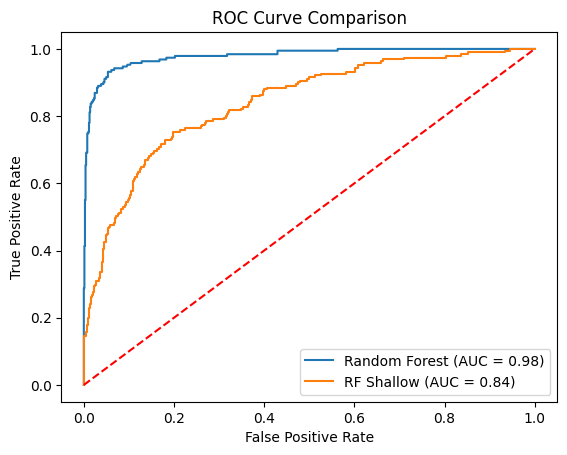

In [33]:
models = [
    {
        'label': 'Random Forest',
        'model': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=2, max_features=8)
    },
    {
        'label': 'RF Shallow',
        'model': RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=2, max_features=8)
    }
]
## Plot AUC ROC Curve
plt.figure()

# Create loop through all models
for algo in models:
    model = algo['model']
    model.fit(x_train, y_train)
   
    ## Compute False Positive rate and True Positive rate    
    y_prob = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    ## Calculate Area under the curve
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (algo['label'], auc))

plt.plot([0,1], [0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
